# 1.导入包及数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
from vmdpy import VMD  
import akshare as ak #大豆数据集
from scipy.fftpack import fft ##傅里叶级数
import pkuseg   #分词包
import re

#下载数据
Data=pd.read_csv("/Volumes/本机/paper/futures voality forcaseting/VMD_BiLSTM_A0/Data/data.csv")
Data.head()


,Unnamed: 0,date,open,high,low,close,volume,hold,settle,return,volatility
0,1,2010/1/4,4080,4090,4049,4057,321838,284296,0,0.00000,0.0
1,2,2010/1/5,4067,4082,4060,4066,253640,283384,0,0.00222,0.0
2,3,2010/1/6,4066,4194,4057,4154,860812,352830,0,0.02141,0.0
3,4,2010/1/7,4165,4188,3975,4044,705704,297236,0,-0.02684,0.0
4,5,2010/1/8,4040,4050,3947,3981,526594,270074,0,-0.01570,0.0


In [2]:
#数据处理
pd.to_datetime(Data.date)
Data.drop(columns={'Unnamed: 0'},inplace=True)
Data.head()

,date,open,high,low,close,volume,hold,settle,return,volatility
0,2010/1/4,4080,4090,4049,4057,321838,284296,0,0.00000,0.0
1,2010/1/5,4067,4082,4060,4066,253640,283384,0,0.00222,0.0
2,2010/1/6,4066,4194,4057,4154,860812,352830,0,0.02141,0.0
3,2010/1/7,4165,4188,3975,4044,705704,297236,0,-0.02684,0.0
4,2010/1/8,4040,4050,3947,3981,526594,270074,0,-0.01570,0.0


# 2.VMD分解 Return&Volatility 

### vmd参数设置及绘制分解模态图

Text(0.5, 1.0, 'Decomposed modes of volatility')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


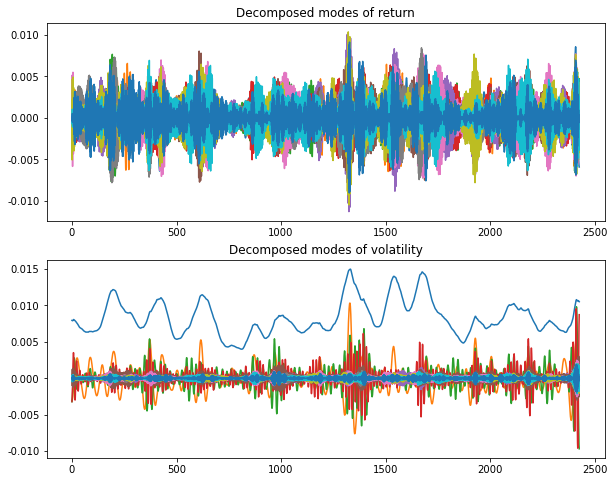

In [3]:
#1.导入文件，可以指定列也可以，就是usecols
filename= '/Volumes/本机/paper/futures voality forcaseting/VMD_BiLSTM_A0/Data/data.csv'
f = pd.read_csv(filename,usecols=[9,10])

#vmd包参数设置并执行VMD
alpha = 5000       #宽带限制，一般为数据点的1.5-2倍  
tau = 0.           # 噪声限制 (no strict fidelity enforcement)  
K = 11             # 分解模态个数  
DC = 0             # 合成信号若无常量则为0；若含常量，则其取值为 1；  
init = 1           # 初始化ω值,当初始化为1时,均匀分布产生的随机数； 
tol = 1e-7         # 控制误差大小常量，决定精度与迭代次数

u, u_hat, omega = VMD(f['return'], alpha, tau, K, DC, init, tol)  
u1,u1_hat,omega1 = VMD(f['volatility'], alpha, tau, K, DC, init, tol)  
#绘制分解模态图
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(u.T)
plt.title('Decomposed modes of return')
plt.subplot(2,1,2)
plt.plot(u1.T)
plt.title('Decomposed modes of volatility')


### IMF of return

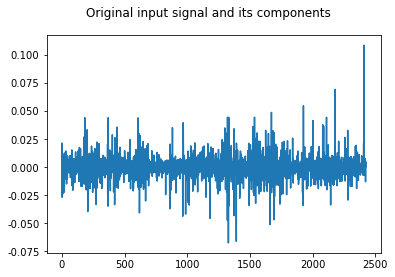

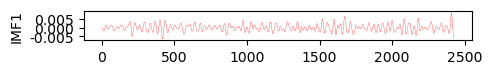

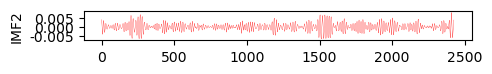

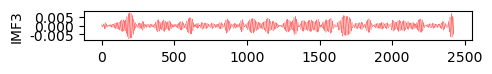

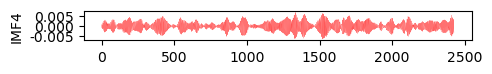

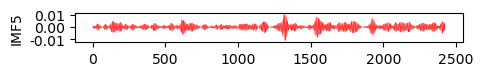

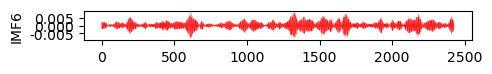

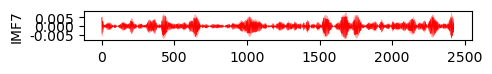

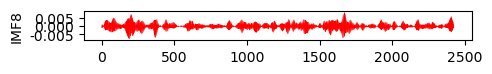

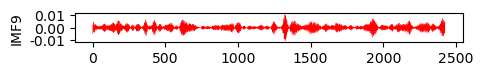

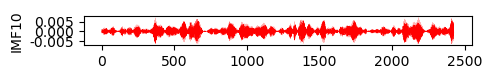

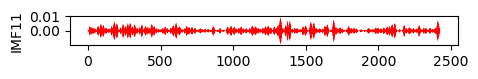

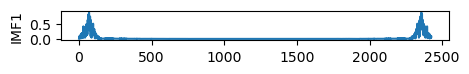

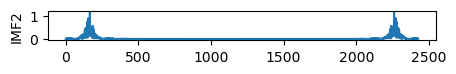

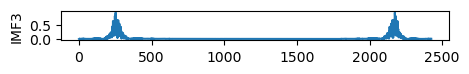

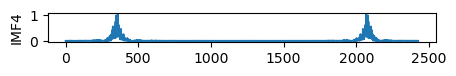

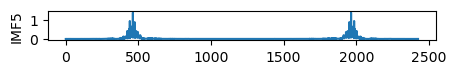

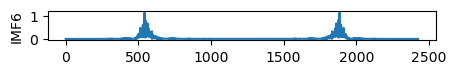

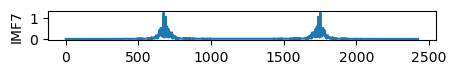

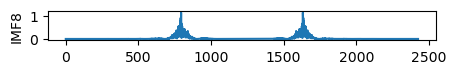

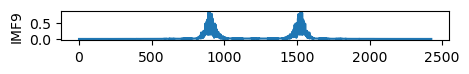

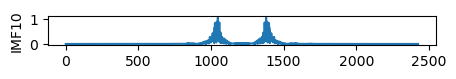

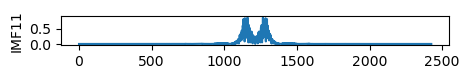

In [4]:
#未分解前的图
fig_return = plt.figure()
plt.plot(f['return'])
fig_return.suptitle('Original input signal and its components')

#循环每个分解模态的
for i in range(K):
    plt.figure(figsize=(5,5), dpi=100)
    plt.subplot(K,1,i+1)
    plt.plot(u[i,:], linewidth=0.2, c='r')
    plt.ylabel('IMF{}'.format(i+1))
    
    #每个模态的中心频率
for i in range(K):
    plt.figure(figsize=(5,5), dpi=100)
    plt.subplot(K,1,i+1)
    plt.plot(abs(fft(u[i,:])))
    plt.ylabel('IMF{}'.format(i+1))



### IMF of volatility

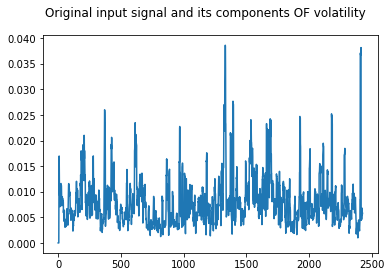

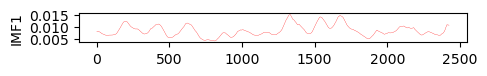

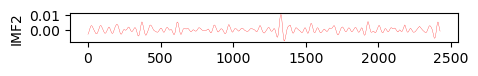

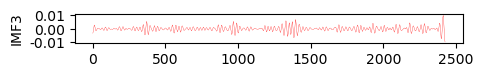

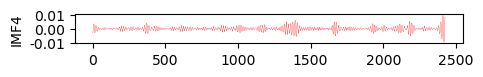

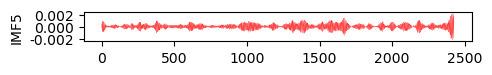

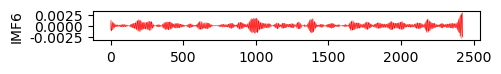

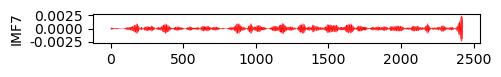

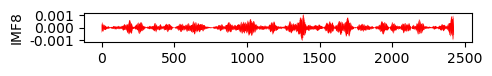

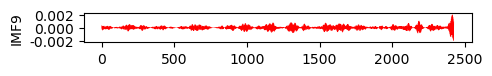

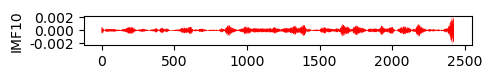

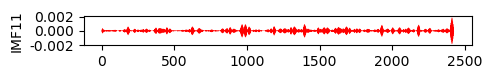

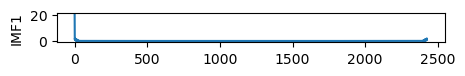

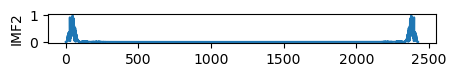

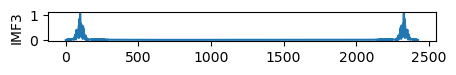

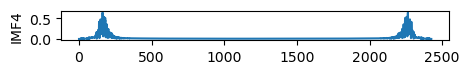

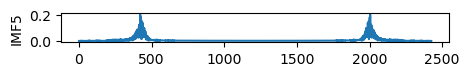

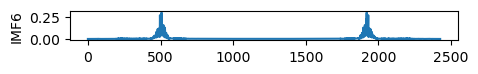

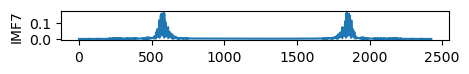

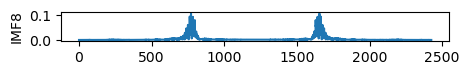

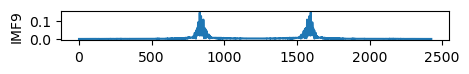

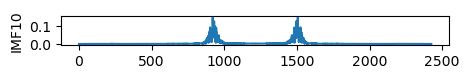

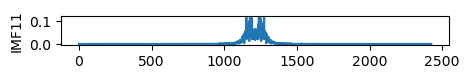

In [5]:
#未分解前的图
fig_volatility = plt.figure()
plt.plot(f['volatility'])
fig_volatility.suptitle('Original input signal and its components OF volatility')

#循环每个分解模态的
for i in range(K):
    plt.figure(figsize=(5,5), dpi=100)
    plt.subplot(K,1,i+1)
    plt.plot(u1[i,:], linewidth=0.2, c='r')
    plt.ylabel('IMF{}'.format(i+1))
    
    #每个模态的中心频率
for i in range(K):
    plt.figure(figsize=(5,5), dpi=100)
    plt.subplot(K,1,i+1)
    plt.plot(abs(fft(u1[i,:])))
    plt.ylabel('IMF{}'.format(i+1))

# 3.文本处理

In [6]:
filepath1='/Volumes/本机/paper/futures voality forcaseting/VMD_BiLSTM_A0/Data/text.csv'
text=pd.read_csv(filepath1)
pd.to_datetime(text.date)

0      2019-07-01
1      2019-06-06
2      2019-05-13
3      2019-04-25
4      2019-04-08
          ...    
3286   2010-01-06
3287   2010-01-05
3288   2010-01-05
3289   2010-01-04
3290   2010-01-04
Name: date, Length: 3291, dtype: datetime64[ns]

### 文本去除标点

In [7]:
titles=text.title
titles1=[]

for i in range(len(titles)):
    textgo = re.sub('[^\u4e00-\u9fa5_a-zA-Z0-9]','',str(titles[i]))
    titles1.append(textgo) 


In [8]:
len(titles1)

3291

### 文本分词

In [9]:
type(titles1)

list

In [10]:
seg = pkuseg.pkuseg() # 以默认配置加载模型

In [11]:
textcut=[]
for j in titles1:  
    textfo=seg.cut( j )  # 进行分词
    textcut.append(textfo)
    
text_cut=pd.Series(textcut)##list换series，然后放入表中


In [12]:
text.insert(loc=1,column='text_cut',value=text_cut)

In [13]:
text

,title,text_cut,date
0,中美元首会晤，习近平同特朗普谈了这些大事,"[中, 美元, 首, 会晤, 习近平, 同, 特朗普, 谈, 了, 这些, 大事]",2019/7/1
1,投机基金仍然看空大豆市场，但是过去一周减持净空单,"[投机, 基金, 仍然, 看空, 大豆, 市场, 但是, 过去, 一, 周, 减持, 净空单]",2019/6/6
2,香港查出非洲猪瘟病毒感染政府销毁上水屠宰场600头生猪,"[香港, 查出, 非洲, 猪瘟, 病毒, 感染, 政府, 销毁, 上水, 屠宰场, 600,...",2019/5/13
3,投机基金在CBOT大豆期市的净空单创下15个月新高,"[投机, 基金, 在, CBOT, 大豆, 期市, 的, 净空单, 创下, 15, 个, 月...",2019/4/25
4,西藏自治区林芝市发生非洲猪瘟疫情,"[西藏, 自治区, 林芝市, 发生, 非洲, 猪瘟, 疫情]",2019/4/8
...,...,...,...
3286,美国大豆进口订货量过高，或造成供过于求,"[美国, 大豆, 进口, 订货量, 过, 高, 或, 造成, 供过于求]",2010/1/6
3287,政策预期助推农产品期货走强,"[政策, 预期, 助推, 农产品, 期货, 走强]",2010/1/5
3288,78家大豆加工企业暂被取消补贴资格,"[78, 家, 大豆, 加工, 企业, 暂, 被, 取消, 补贴, 资格]",2010/1/5
3289,关于东北大豆市场补贴消息播报,"[关于, 东北, 大豆, 市场, 补贴, 消息, 播报]",2010/1/4


### 去除停用词（采用中文停用词表）

In [14]:
def stopwordslist(filepath):   # 定义函数创建停用词列表
    stopword = [line.strip() for line in open(filepath, 'r').readlines()]    #以行的形式读取停用词表，同时转换为列表
    return stopword

filepath='/Volumes/本机/learning/NLP/stopwords/stopwords-master/cn_stopwords.txt'
stopwords = stopwordslist(filepath)

In [15]:
text_cut[0][1]

'美元'

In [16]:
type(text_cut)

pandas.core.series.Series

In [17]:
lastsentences=[]
for i in range(len(text_cut)):     #for循环遍历分词后的每个词语
    lastsentence=[]
    for word in text_cut[i]:
        if word not in stopwords:     #判断分词后的词语是否在停用词表内
            lastsentence.append(word)
    lastsentences.append(lastsentence)
text_cut_stopwords=pd.Series(lastsentences)
text.insert(loc=2,column='text_cut_stopwords',value=text_cut_stopwords)

In [18]:
text

,title,text_cut,text_cut_stopwords,date
0,中美元首会晤，习近平同特朗普谈了这些大事,"[中, 美元, 首, 会晤, 习近平, 同, 特朗普, 谈, 了, 这些, 大事]","[中, 美元, 首, 会晤, 习近平, 特朗普, 谈, 大事]",2019/7/1
1,投机基金仍然看空大豆市场，但是过去一周减持净空单,"[投机, 基金, 仍然, 看空, 大豆, 市场, 但是, 过去, 一, 周, 减持, 净空单]","[投机, 基金, 仍然, 看空, 大豆, 市场, 过去, 周, 减持, 净空单]",2019/6/6
2,香港查出非洲猪瘟病毒感染政府销毁上水屠宰场600头生猪,"[香港, 查出, 非洲, 猪瘟, 病毒, 感染, 政府, 销毁, 上水, 屠宰场, 600,...","[香港, 非洲, 猪瘟, 病毒, 感染, 政府, 销毁, 上水, 屠宰场, 600, 头, 生猪]",2019/5/13
3,投机基金在CBOT大豆期市的净空单创下15个月新高,"[投机, 基金, 在, CBOT, 大豆, 期市, 的, 净空单, 创下, 15, 个, 月...","[投机, 基金, CBOT, 大豆, 期市, 净空单, 15, 月, 新高]",2019/4/25
4,西藏自治区林芝市发生非洲猪瘟疫情,"[西藏, 自治区, 林芝市, 发生, 非洲, 猪瘟, 疫情]","[西藏, 自治区, 林芝市, 非洲, 猪瘟, 疫情]",2019/4/8
...,...,...,...,...
3286,美国大豆进口订货量过高，或造成供过于求,"[美国, 大豆, 进口, 订货量, 过, 高, 或, 造成, 供过于求]","[美国, 大豆, 进口, 订货量, 高, 造成, 供过于求]",2010/1/6
3287,政策预期助推农产品期货走强,"[政策, 预期, 助推, 农产品, 期货, 走强]","[政策, 预期, 助推, 农产品, 期货, 走强]",2010/1/5
3288,78家大豆加工企业暂被取消补贴资格,"[78, 家, 大豆, 加工, 企业, 暂, 被, 取消, 补贴, 资格]","[78, 家, 大豆, 加工, 企业, 暂, 取消, 补贴, 资格]",2010/1/5
3289,关于东北大豆市场补贴消息播报,"[关于, 东北, 大豆, 市场, 补贴, 消息, 播报]","[东北, 大豆, 市场, 补贴, 消息, 播报]",2010/1/4
